In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import os

data_dir = "../../kaggle/hms-eeg/data/data/" 

df = pd.read_csv(os.path.join(data_dir, "train.csv"))

In [4]:
import numpy as np
import librosa 
import math

from scipy.signal import butter
from scipy.signal import filtfilt

def mad(signal: np.ndarray, axis: int = -1, keepdims: bool = True) -> np.ndarray:
    """Compute the robust standard deviation (MAD) of a signal."""
    median = np.median(signal, axis = axis, keepdims = keepdims)
    mad = np.median(np.abs(signal - median), axis = axis, keepdims = keepdims)
    return mad * 1.4826  # This is a constant for normal distribution

def butter_filter(
    signal: np.ndarray, 
    fs: int = 200, 
    cutoff_freq: np.ndarray = np.array([0.25, 50]), 
    order: int = 4, 
    btype: str = "bandpass"
) -> np.ndarray:
    """ 
    """
    b, a = butter(
        N = order, 
        Wn = cutoff_freq / (0.5 * fs), 
        btype = btype,
        analog = False
    )
    return filtfilt(b, a, signal)

def get_spectrogram(eeg: np.ndarray) -> np.ndarray:
    eeg = butter_filter(eeg)
    eeg = eeg / mad(eeg)
    eeg = eeg.clip(-10, 10)
    
    spectrogram = librosa.stft(
        eeg, n_fft = 1024, hop_length = 39, win_length = 400, 
        window = "hann", center = True, pad_mode = "constant", 
        out = None, dtype = None
    )
    spectrogram = librosa.power_to_db(
        np.abs(spectrogram) ** 2.2, ref = np.max
    ).astype(np.float32)
    spectrogram = (spectrogram + 80) / 80
    return spectrogram[:200]


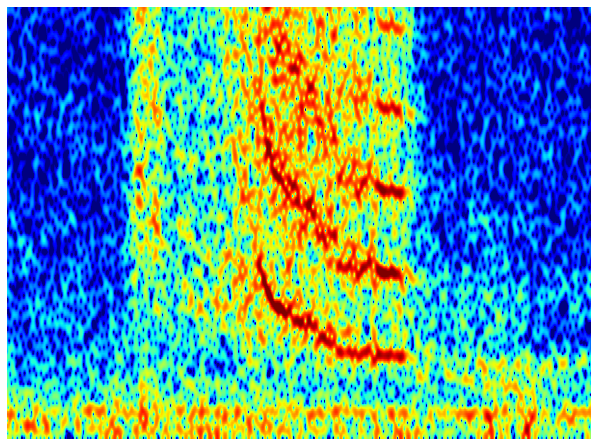

In [5]:
# [91, 99, 177, 336, 395, 399, 409, 735, 759, 791, 850, 854, 856, 973]:
    
i = 759
eeg_id = df["eeg_id"].unique()[i]
path = os.path.join(data_dir, f"train_eegs/{eeg_id}.parquet")

df_eeg = pl.read_parquet(path)

fp1 = df_eeg["Fp1"].to_numpy()
f7 = df_eeg["F7"].to_numpy()
image = get_spectrogram(fp1-f7) 
image = image[:, 10:-10]

o = 3
fig, ax = plt.subplots(figsize = (3*o, 2*o))
ax.imshow(image, cmap = "jet", vmin = 0.4, vmax = 0.95, aspect = "auto")
ax.invert_yaxis()

ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")
plt.subplots_adjust(top = 1, bottom = 0, right = 0.9, left = 0)

plt.savefig(
    "./hbac_cover.png", 
    transparent = False, 
    bbox_inches = "tight", 
    pad_inches = 0,
    dpi = 300
)

plt.show()